# BQML - ARIMA+ univariate

In [1]:
GCP_PROJECTS = !gcloud config get-value project
PROJECT_ID = GCP_PROJECTS[0]
PROJECT_NUM = !gcloud projects list --filter="$PROJECT_ID" --format="value(PROJECT_NUMBER)"
PROJECT_NUM = PROJECT_NUM[0]
LOCATION = 'us-central1'
REGION = "us-central1"

# VERTEX_SA = '934903580331-compute@developer.gserviceaccount.com'
VERTEX_SA = 'jt-vertex-sa@hybrid-vertex.iam.gserviceaccount.com'

print(f"PROJECT_ID: {PROJECT_ID}")
print(f"PROJECT_NUM: {PROJECT_NUM}")
print(f"LOCATION: {LOCATION}")
print(f"REGION: {REGION}")
print(f"VERTEX_SA: {VERTEX_SA}")

PROJECT_ID: hybrid-vertex
PROJECT_NUM: 934903580331
LOCATION: us-central1
REGION: us-central1
VERTEX_SA: jt-vertex-sa@hybrid-vertex.iam.gserviceaccount.com


In [3]:
VERSION='jtv4'

In [4]:
REGION = 'us-central1'
EXPERIMENT = 'forecasting-2'
SERIES = f'{VERSION}-forecasting'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = 'forecasting-1'

viz_limit = 12

EXPERIMENT_NAME = f"nyc_{BQ_DATASET}"
print(f'EXPERIMENT_NAME: {EXPERIMENT_NAME}')

EXPERIMENT_NAME: nyc_jtv4_forecasting


In [5]:
from google.cloud import bigquery

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

from google.cloud import aiplatform as vertex_ai

In [6]:
bq = bigquery.Client(project=PROJECT_ID)

vertex_ai.init(
    project=PROJECT_ID, 
    location=REGION,
    # credentials=credentials
)

## review time series

In [7]:
# CUSTOMIZE
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'

In [8]:
query = f"""
    WITH
        SPLIT AS (
            SELECT splits, min({TIME_COLUMN}) as mindate, max({TIME_COLUMN}) as maxdate
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            GROUP BY splits
        ),
        TRAIN AS (
            SELECT mindate as start_date
            FROM SPLIT
            WHERE splits ='TRAIN'
        ),
        VAL AS (
            SELECT mindate as val_start
            FROM SPLIT
            WHERE splits = 'VALIDATE'
        ),
        TEST AS (
            SELECT mindate as test_start, maxdate as end_date
            FROM SPLIT
            WHERE splits = 'TEST'
        )
    SELECT * EXCEPT(pos) FROM
    (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
    USING (pos)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
    USING (pos)
"""
keyDates = bq.query(query).to_dataframe()
keyDates

start_date   val_start  test_start    end_date
0  2013-07-01  2016-09-03  2016-09-17  2016-09-30

In [9]:
query = f"""
    SELECT {SERIES_COLUMN}, {TIME_COLUMN}, splits, {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq.query(query).to_dataframe()

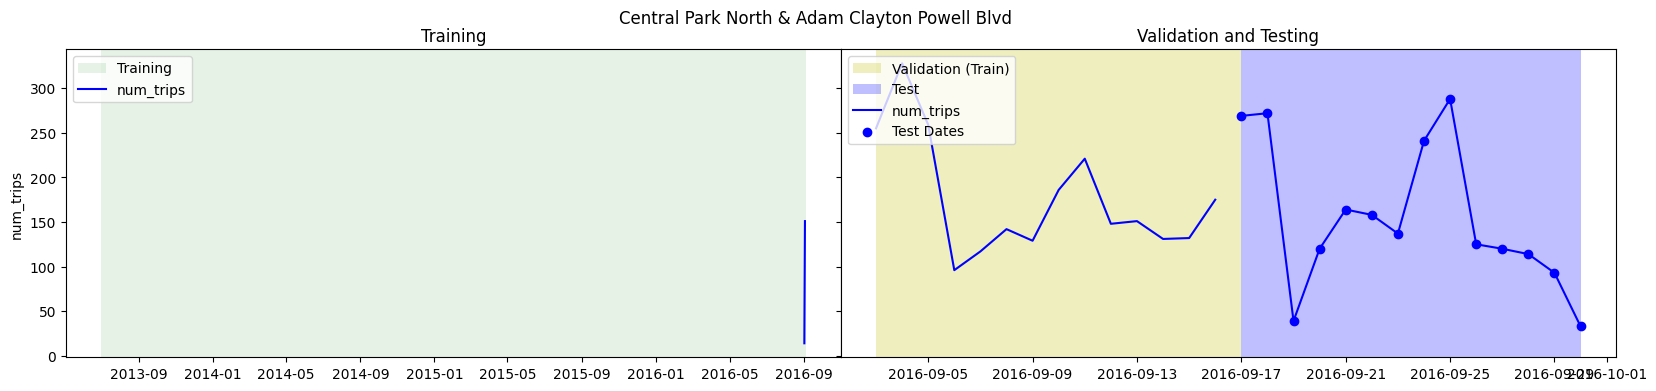

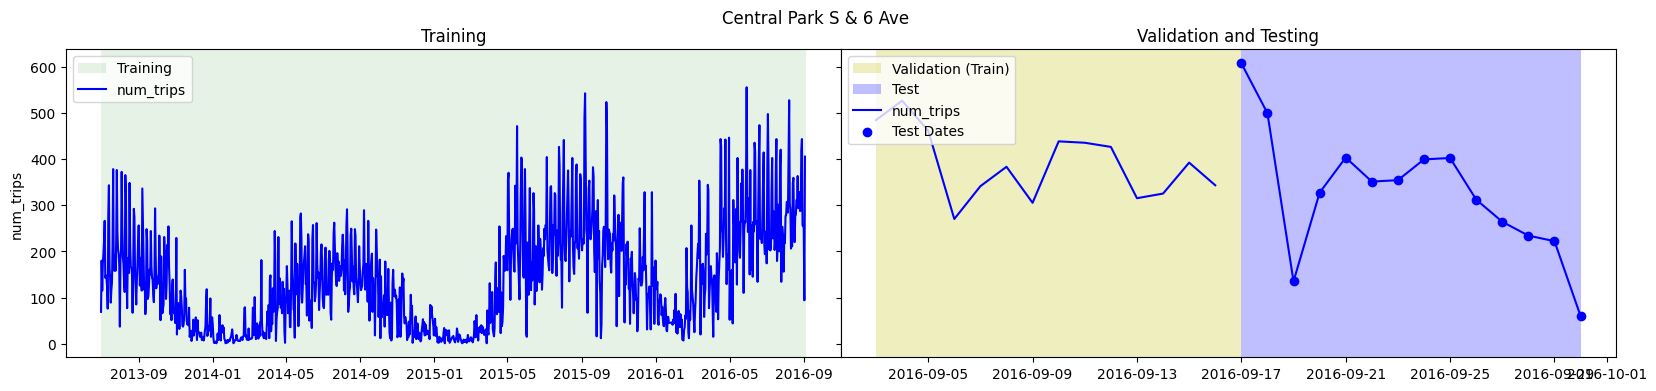

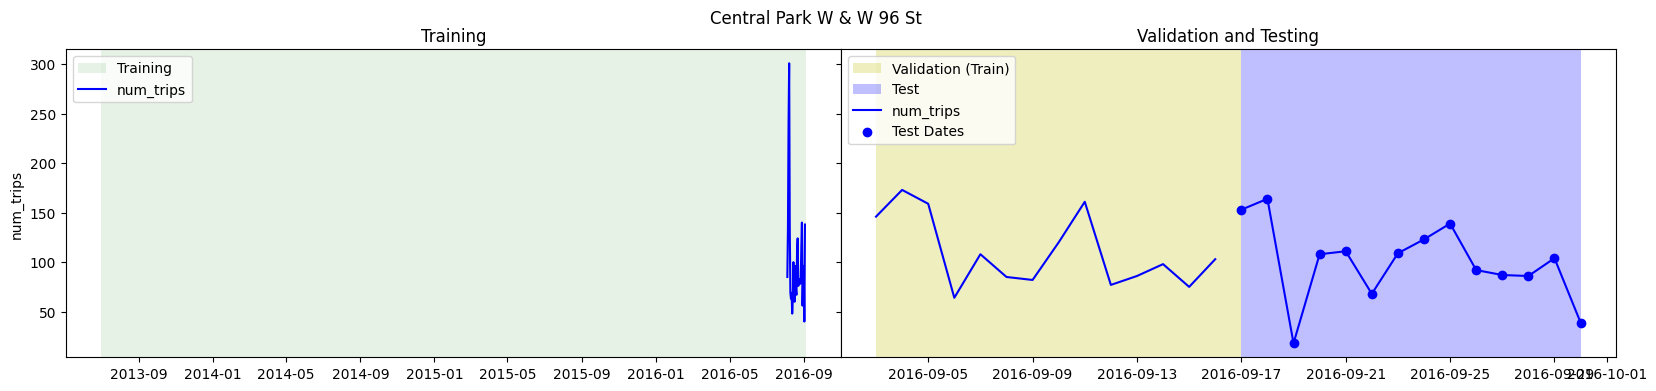

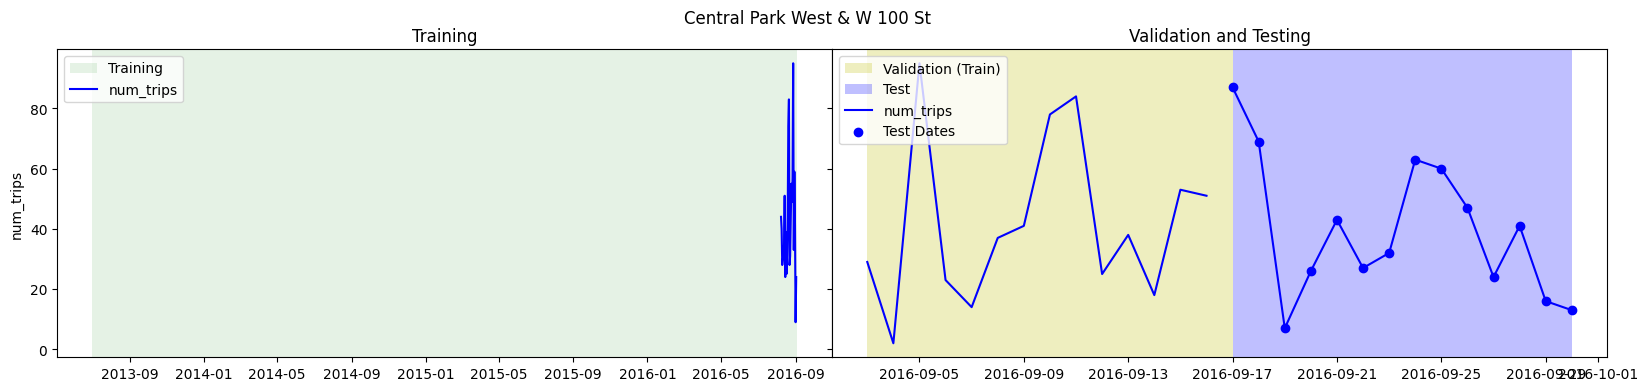

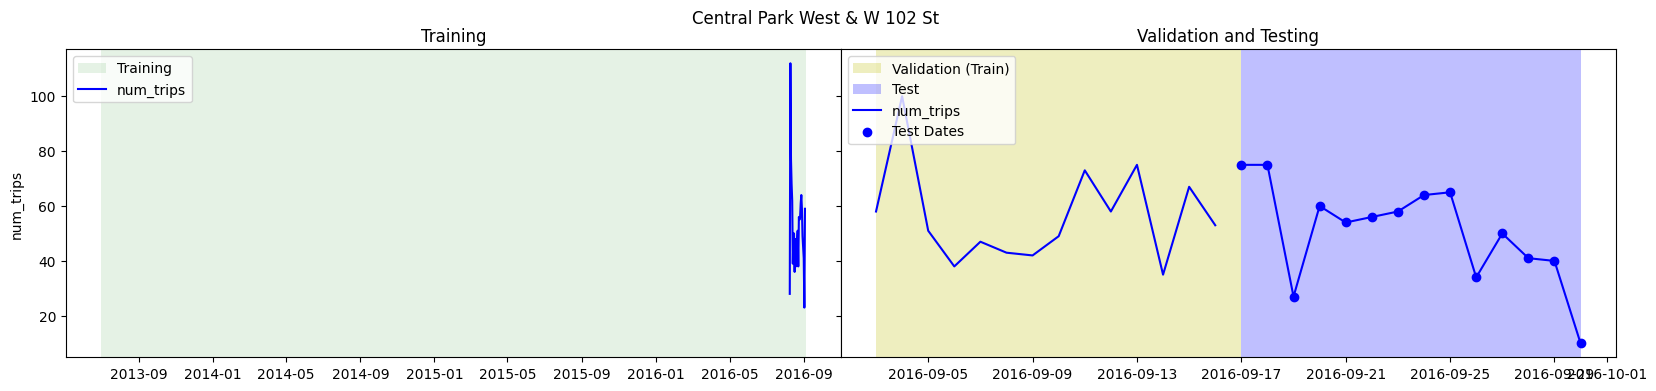

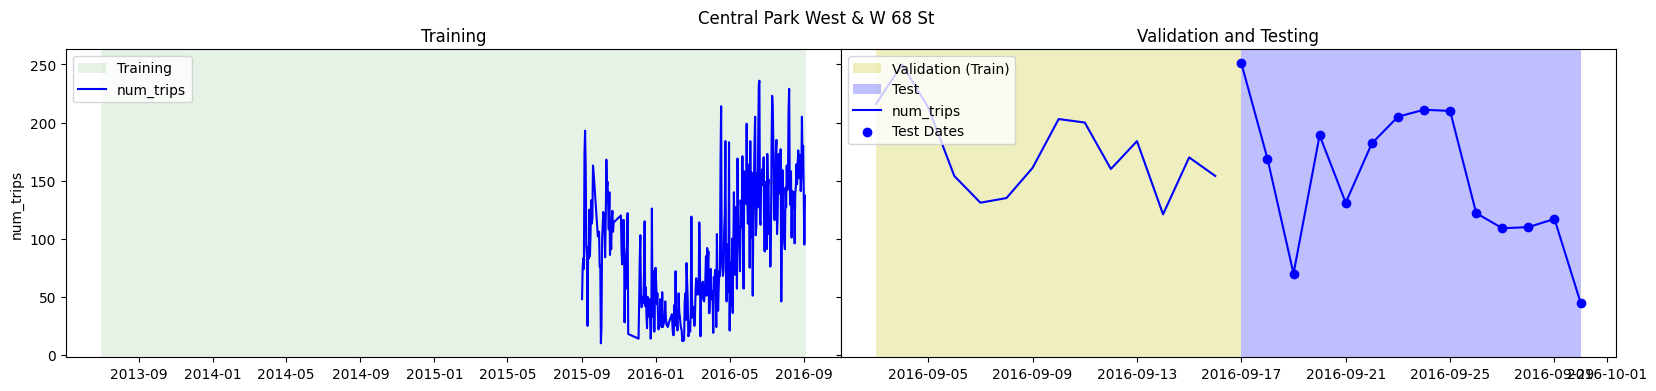

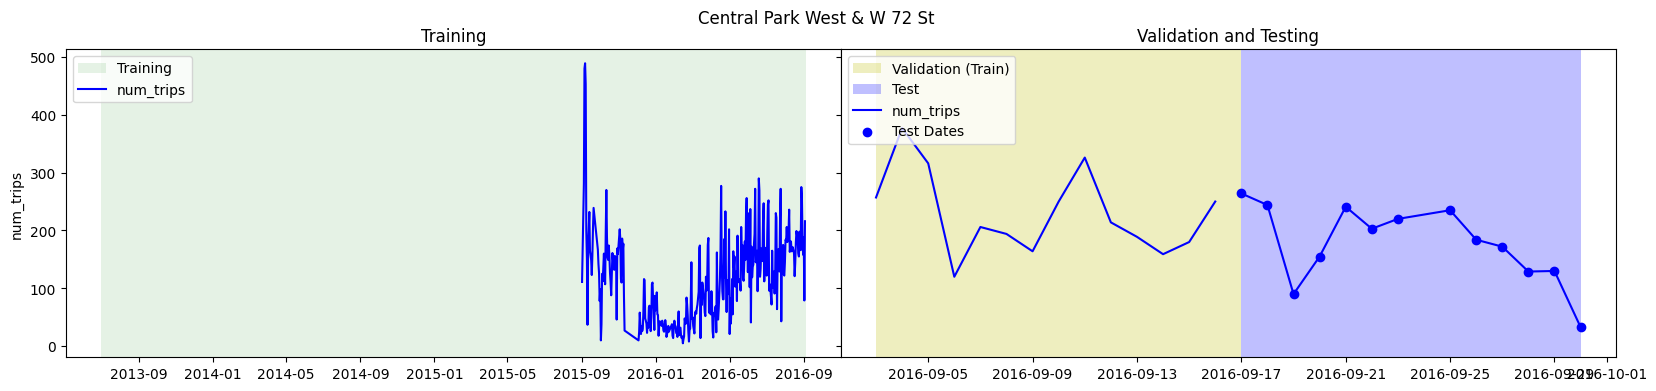

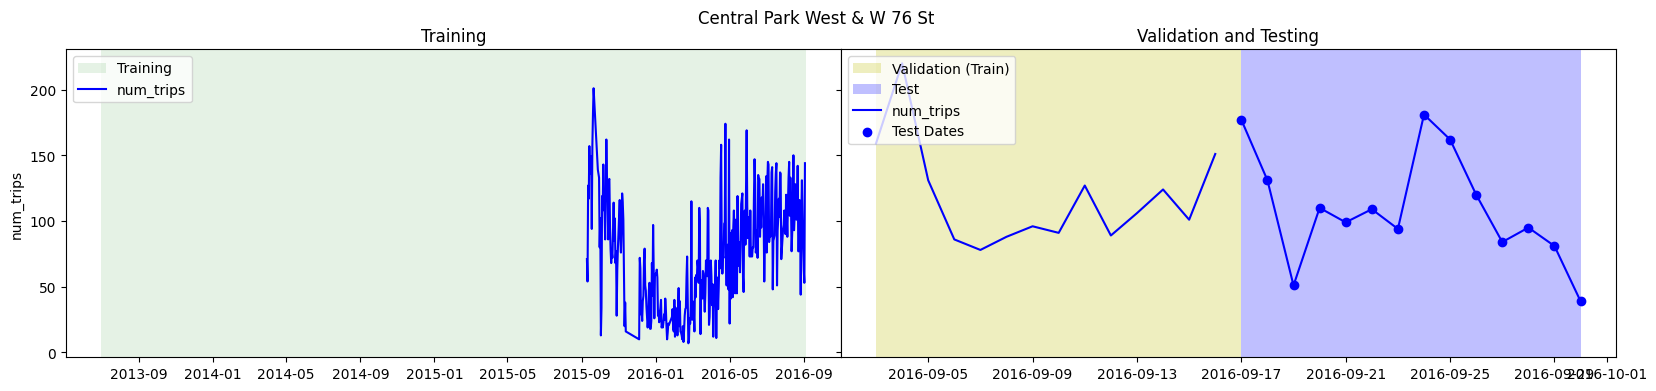

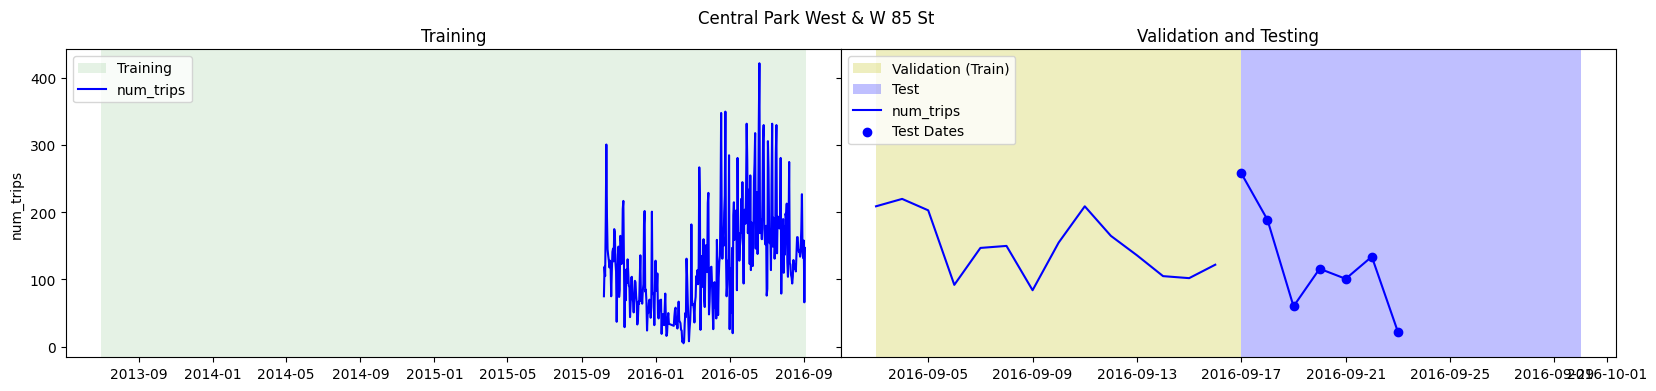

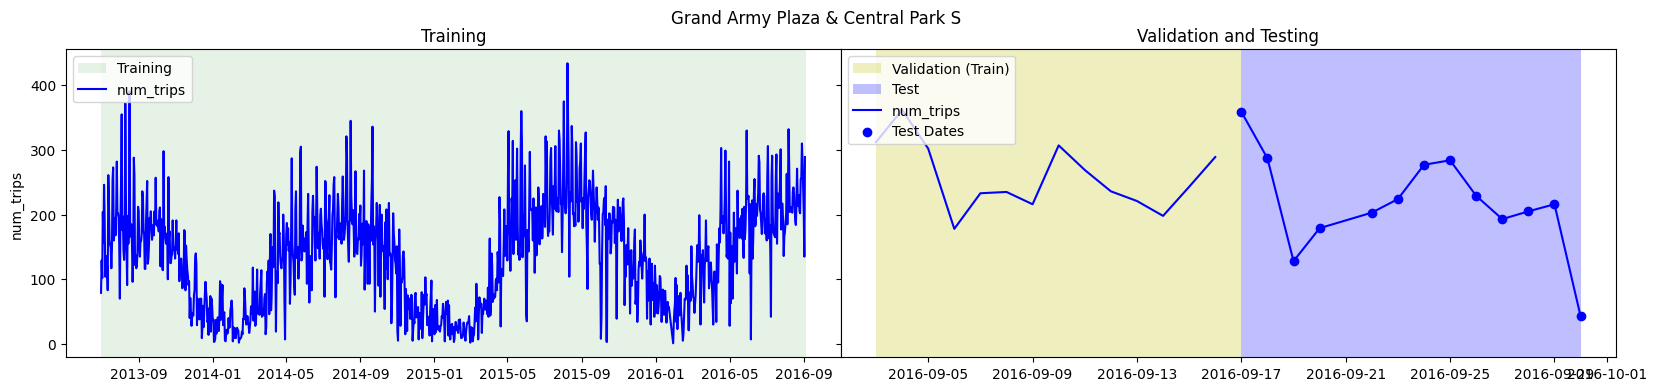

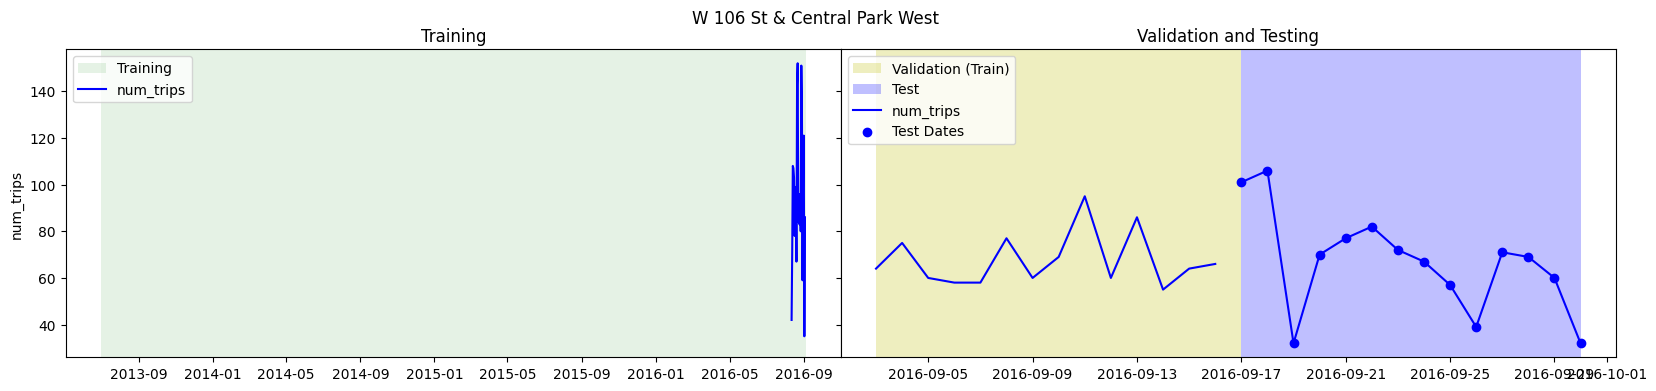

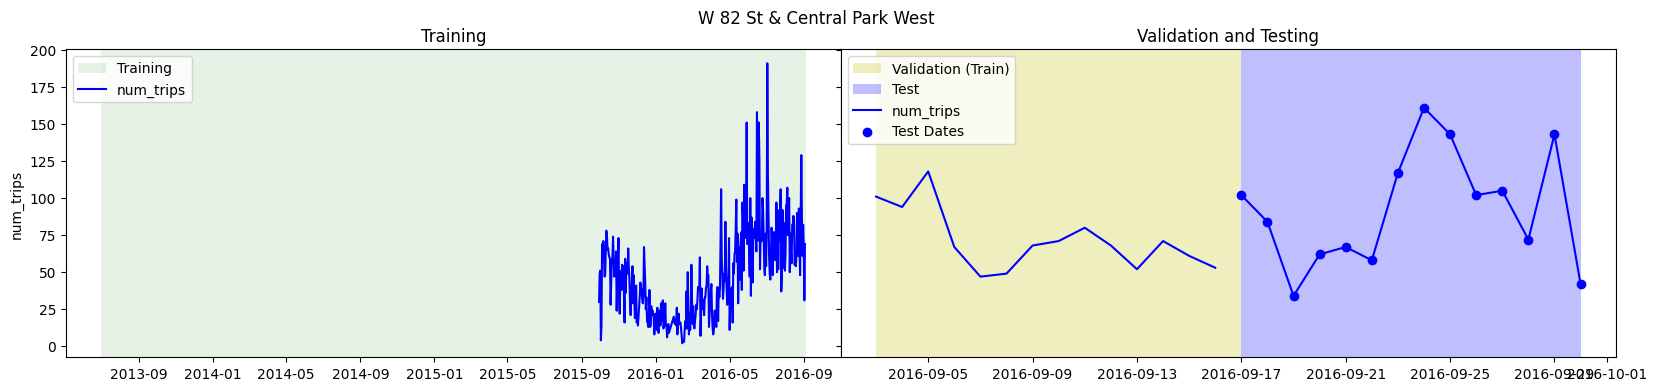

In [10]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')

        # lines and dots
        axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')
        axes[1].scatter(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b', label = 'Test Dates')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st)

        # display result
        plt.show()

# Create Forecast Model

In [12]:
# CUSTOMIZE
forecast_granularity = 'DAY'
forecast_horizon = 14
forecast_test_length = 14
#forecast_val_length = 14

VERTEX_AI_MODEL_ID='v1_arima'
MODEL_VERSION='v2'
XAI_FLAG="TRUE"

In [13]:
query = f"""
    CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus_{MODEL_VERSION}`
    OPTIONS
      (model_type = 'ARIMA_PLUS',
       time_series_timestamp_col = '{TIME_COLUMN}',
       time_series_data_col = '{TARGET_COLUMN}',
       time_series_id_col = '{SERIES_COLUMN}',
       auto_arima_max_order = 5,
       holiday_region = 'US',
       horizon = {forecast_horizon}+{forecast_test_length},
       -- Vertex AI fields
       model_registry="vertex_ai", 
       vertex_ai_model_id='{VERTEX_AI_MODEL_ID}',
       vertex_ai_model_version_aliases=['{MODEL_VERSION}', 'experimental']
       -- enable_global_explain={XAI_FLAG}
      ) AS
    SELECT {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    WHERE splits in ('TRAIN','VALIDATE')
"""
print(query)


    CREATE OR REPLACE MODEL `hybrid-vertex.jtv4_forecasting.forecasting-1_arimaplus_v2`
    OPTIONS
      (model_type = 'ARIMA_PLUS',
       time_series_timestamp_col = 'starttime',
       time_series_data_col = 'num_trips',
       time_series_id_col = 'start_station_name',
       auto_arima_max_order = 5,
       holiday_region = 'US',
       horizon = 14+14,
       -- Vertex AI fields
       model_registry="vertex_ai", 
       vertex_ai_model_id='v1_arima',
       vertex_ai_model_version_aliases=['v2', 'experimental']
       -- enable_global_explain=TRUE
      ) AS
    SELECT start_station_name, starttime, num_trips
    FROM `hybrid-vertex.jtv4_forecasting.forecasting-1_prepped`
    WHERE splits in ('TRAIN','VALIDATE')



In [ ]:
job = bq.query(query)
job.result()
(job.ended-job.started).total_seconds()

## review ARIMA coefficients

In [13]:
query = f"""
    SELECT *
    FROM ML.ARIMA_COEFFICIENTS(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus_{MODEL_VERSION}`)
    ORDER BY {SERIES_COLUMN}
"""
coefficients = bq.query(query).to_dataframe()
coefficients.head(viz_limit)

start_station_name  \
0   Central Park North & Adam Clayton Powell Blvd   
1                          Central Park S & 6 Ave   
2                        Central Park W & W 96 St   
3                    Central Park West & W 100 St   
4                    Central Park West & W 102 St   
5                     Central Park West & W 68 St   
6                     Central Park West & W 72 St   
7                     Central Park West & W 76 St   
8                     Central Park West & W 85 St   
9               Grand Army Plaza & Central Park S   
10                   W 106 St & Central Park West   
11                    W 82 St & Central Park West   

                                      ar_coefficients  \
0                                                  []   
1                                                  []   
2                                 [0.606197201087799]   
3                                [0.3518355980348823]   
4                                                  []   
5                                                  []   
6                                                  []   
7   [0.47934796064540913, -0.0023414166630521607, ...   
8                                                  []   
9                                                  []   
10         [-0.8405445660286137, -0.5496718463096316]   
11                                                 []   

                                      ma_coefficients  intercept_or_drift  
0   [0.4367042956076374, -0.016512649634778276, -0...          169.292694  
1   [-0.7550157771719312, -0.30419031624058557, 0....            0.000000  
2                                                  []          104.092507  
3                                                  []           40.380671  
4   [0.024759641179645575, 0.20624615867712248, -0...           52.152300  
5   [-0.48856445944061444, 0.1414186480770465, -0....            0.000000  
6   [-0.3543404833888051, 0.2554998441517188, -0.5...            0.000000  
7                                [-0.950992024436627]            0.348445  
8   [-0.3901300567684862, -0.7393964989036537, 0.7...            0.000000  
9   [-0.7257812143959839, -0.2866678593277397, 0.5...            0.000000  
10                                                 []            0.000000  
11  [-0.8173891009542463, -0.14621707877386442, 0....            0.000000

In [14]:
query = f"""
    SELECT *
    FROM ML.FEATURE_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus_{MODEL_VERSION}`)
"""
featureInfo = bq.query(query).to_dataframe()
featureInfo.head()

input  min    max        mean  median     stddev  \
0           num_trips  1.0  555.0  119.446128   100.0  87.921883   
1           starttime  NaN    NaN         NaN     NaN        NaN   
2  start_station_name  NaN    NaN         NaN     NaN        NaN   

   category_count  null_count  dimension  
0            <NA>           0       <NA>  
1            1170           0       <NA>  
2              12           0       <NA>

In [15]:
query = f"""
    SELECT *
    FROM ML.TRAINING_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus_{MODEL_VERSION}`)
"""
trainingInfo = bq.query(query).to_dataframe()
trainingInfo.head()

training_run  iteration  duration_ms
0             0          0         7550

## Forecast Evaluation

In [16]:
query = f"""
    SELECT *
    FROM ML.EVALUATE(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus_{MODEL_VERSION}`,
    (
        SELECT {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN}
        FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
        WHERE splits = 'TEST'
        ORDER BY {SERIES_COLUMN}
    ),
    STRUCT(TRUE AS perform_aggregation))
"""
metrics = bq.query(query).to_dataframe()
metrics.head(viz_limit)

start_station_name  mean_absolute_error  \
0   Central Park North & Adam Clayton Powell Blvd            40.519533   
1                          Central Park S & 6 Ave            96.392810   
2                        Central Park W & W 96 St            21.729312   
3                    Central Park West & W 100 St            18.610058   
4                    Central Park West & W 102 St            14.568555   
5                     Central Park West & W 68 St            47.343426   
6                     Central Park West & W 72 St            46.421029   
7                     Central Park West & W 76 St            27.917248   
8                     Central Park West & W 85 St            53.979223   
9               Grand Army Plaza & Central Park S            56.139488   
10                   W 106 St & Central Park West            14.356956   
11                    W 82 St & Central Park West            32.113632   

    mean_squared_error  root_mean_squared_error  \
0          3339.344260                57.787060   
1         16518.326662               128.523642   
2          1016.374801                31.880634   
3           482.209233                21.959263   
4           332.562812                18.236305   
5          3120.673286                55.862987   
6          5039.529907                70.989646   
7          1238.418789                35.191175   
8          4709.508389                68.625858   
9          5640.988045                75.106511   
10          323.219810                17.978315   
11         1781.537621                42.208265   

    mean_absolute_percentage_error  symmetric_mean_absolute_percentage_error  
0                        65.497641                                 32.165275  
1                        48.584716                                 35.670070  
2                        54.169130                                 27.164336  
3                        87.537112                                 50.606040  
4                        53.150445                                 32.238560  
5                        49.545486                                 33.571445  
6                        67.705234                                 29.676367  
7                        38.946708                                 27.214789  
8                        95.295942                                 49.453879  
9                        49.744836                                 30.236943  
10                       27.530929                                 22.766975  
11                       34.276921                                 37.675419

## Evaluate time series
* Reference for `ML.ARIMA_EVALUATE`

A model metrics table: ARIMA terms:

* p = how many autoregressive terms
* d = how many nonseasonal differences needed for stationarity
* q = number of lagged forecast errors (moving average part)

In [17]:
query = f"""
    SELECT *
    FROM ML.ARIMA_EVALUATE(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus_{MODEL_VERSION}`)
    ORDER BY {SERIES_COLUMN}
"""
arima_metrics = bq.query(query).to_dataframe()
arima_metrics.head(viz_limit)

start_station_name  non_seasonal_p  \
0   Central Park North & Adam Clayton Powell Blvd               0   
1                          Central Park S & 6 Ave               0   
2                        Central Park W & W 96 St               1   
3                    Central Park West & W 100 St               1   
4                    Central Park West & W 102 St               0   
5                     Central Park West & W 68 St               0   
6                     Central Park West & W 72 St               0   
7                     Central Park West & W 76 St               3   
8                     Central Park West & W 85 St               0   
9               Grand Army Plaza & Central Park S               0   
10                   W 106 St & Central Park West               2   
11                    W 82 St & Central Park West               0   

    non_seasonal_d  non_seasonal_q  has_drift  log_likelihood           AIC  \
0                0               4      False      -76.109993    164.219985   
1                1               5      False    -5797.444849  11606.889697   
2                0               0      False     -210.602099    427.204198   
3                0               0      False     -175.395825    356.791651   
4                0               4      False     -165.517414    343.034827   
5                1               5      False    -1711.902812   3435.805624   
6                1               5      False    -1836.246652   3684.493304   
7                1               1       True    -1525.004142   3062.008285   
8                1               5      False    -1710.216785   3432.433571   
9                1               5      False    -5448.162753  10908.325506   
10               1               0      False     -157.275264    320.550529   
11               1               5      False    -1428.194806   2868.389612   

       variance  seasonal_periods  has_holiday_effect  has_spikes_and_dips  \
0    536.704789          [WEEKLY]               False                False   
1   1144.766698  [WEEKLY, YEARLY]                True                 True   
2    832.585329          [WEEKLY]               False                False   
3    375.632216  [NO_SEASONALITY]               False                 True   
4    189.056029  [NO_SEASONALITY]               False                False   
5    465.052298          [WEEKLY]                True                 True   
6    881.974368          [WEEKLY]                True                 True   
7    207.724785          [WEEKLY]                True                 True   
8   1121.729390          [WEEKLY]               False                 True   
9    631.314669  [WEEKLY, YEARLY]                True                 True   
10   354.239747          [WEEKLY]               False                False   
11   186.375832          [WEEKLY]               False                 True   

    has_step_changes error_message  
0              False                
1               True                
2              False                
3              False                
4              False                
5               True                
6               True                
7               True                
8              False                
9               True                
10             False                
11             False

# Forecast Time Series

In [18]:
query = f"""
    SELECT *
    FROM ML.FORECAST(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus_{MODEL_VERSION}`, STRUCT(1 AS horizon, 0.95 AS confidence_level))
    ORDER BY {SERIES_COLUMN}
"""
forecast = bq.query(query).to_dataframe()
forecast.head(viz_limit)

start_station_name        forecast_timestamp  \
0   Central Park North & Adam Clayton Powell Blvd 2016-09-17 00:00:00+00:00   
1                          Central Park S & 6 Ave 2016-09-17 00:00:00+00:00   
2                        Central Park W & W 96 St 2016-09-17 00:00:00+00:00   
3                    Central Park West & W 100 St 2016-09-17 00:00:00+00:00   
4                    Central Park West & W 102 St 2016-09-17 00:00:00+00:00   
5                     Central Park West & W 68 St 2016-09-17 00:00:00+00:00   
6                     Central Park West & W 72 St 2016-09-17 00:00:00+00:00   
7                     Central Park West & W 76 St 2016-09-17 00:00:00+00:00   
8                     Central Park West & W 85 St 2016-09-17 00:00:00+00:00   
9               Grand Army Plaza & Central Park S 2016-09-17 00:00:00+00:00   
10                   W 106 St & Central Park West 2016-09-17 00:00:00+00:00   
11                    W 82 St & Central Park West 2016-09-17 00:00:00+00:00   

    forecast_value  standard_error  confidence_level  \
0       222.073810       25.307050              0.95   
1       358.914431       33.834401              0.95   
2       122.160526       28.854555              0.95   
3        44.116929       19.381234              0.95   
4        45.519928       14.227731              0.95   
5       175.955216       21.565071              0.95   
6       271.568951       29.709517              0.95   
7       146.638151       14.412661              0.95   
8       125.442298       33.683213              0.95   
9       258.716770       25.125976              0.95   
10       78.472703       18.821258              0.95   
11       88.738432       13.674756              0.95   

    prediction_interval_lower_bound  prediction_interval_upper_bound  \
0                        172.561627                       271.585993   
1                        292.718843                       425.110019   
2                         65.707799                       178.613253   
3                          6.198358                        82.035500   
4                         17.683968                        73.355888   
5                        133.764058                       218.146374   
6                        213.443526                       329.694376   
7                        118.440384                       174.835917   
8                         59.542503                       191.342093   
9                        209.558851                       307.874689   
10                        41.649701                       115.295705   
11                        61.984345                       115.492520   

    confidence_interval_lower_bound  confidence_interval_upper_bound  
0                        172.561627                       271.585993  
1                        292.718843                       425.110019  
2                         65.707799                       178.613253  
3                          6.198358                        82.035500  
4                         17.683968                        73.355888  
5                        133.764058                       218.146374  
6                        213.443526                       329.694376  
7                        118.440384                       174.835917  
8                         59.542503                       191.342093  
9                        209.558851                       307.874689  
10                        41.649701                       115.295705  
11                        61.984345                       115.492520

## Forecast + Explanations for Time Series
* Reference for `ML.EXPLAIN_FORECAST`

> NOTE At this point in time (March 2023) the ARIMA_PLUS_XREG is in preview and does not yet use the ML.EXPLAIN_FORECAST function. In preparation for it the results of the forecast table above are used and remapped to the expected column names.

In [19]:
query = f"""
    SELECT *, 
        EXTRACT(DATE FROM time_series_timestamp) AS {TIME_COLUMN}
    FROM ML.EXPLAIN_FORECAST(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus_{MODEL_VERSION}`,
        STRUCT({forecast_horizon+forecast_test_length} AS horizon, 0.95 AS confidence_level))
    ORDER BY {SERIES_COLUMN}, {TIME_COLUMN}
"""
explain = bq.query(query).to_dataframe()

In [20]:
explain.tail()

start_station_name     time_series_timestamp time_series_type  \
4694  W 82 St & Central Park West 2016-10-10 00:00:00+00:00         forecast   
4695  W 82 St & Central Park West 2016-10-11 00:00:00+00:00         forecast   
4696  W 82 St & Central Park West 2016-10-12 00:00:00+00:00         forecast   
4697  W 82 St & Central Park West 2016-10-13 00:00:00+00:00         forecast   
4698  W 82 St & Central Park West 2016-10-14 00:00:00+00:00         forecast   

      time_series_data  time_series_adjusted_data  standard_error  \
4694         73.385875                  73.385875       21.976428   
4695         67.075769                  67.075769       22.103553   
4696         58.180525                  58.180525       22.229951   
4697         43.376116                  43.376116       22.355634   
4698         66.707370                  66.707370       22.480614   

      confidence_level  prediction_interval_lower_bound  \
4694              0.95                        30.389914   
4695              0.95                        23.831094   
4696              0.95                        14.688558   
4697              0.95                        -0.361745   
4698              0.95                        22.724990   

      prediction_interval_upper_bound      trend  seasonal_period_yearly  \
4694                       116.381836  69.507656                     NaN   
4695                       110.320444  69.507656                     NaN   
4696                       101.672492  69.507656                     NaN   
4697                        87.113977  69.507656                     NaN   
4698                       110.689750  69.507656                     NaN   

      seasonal_period_quarterly  seasonal_period_monthly  \
4694                        NaN                      NaN   
4695                        NaN                      NaN   
4696                        NaN                      NaN   
4697                        NaN                      NaN   
4698                        NaN                      NaN   

      seasonal_period_weekly  seasonal_period_daily  holiday_effect  \
4694                3.878220                    NaN             NaN   
4695               -2.431887                    NaN             NaN   
4696              -11.327131                    NaN             NaN   
4697              -26.131540                    NaN             NaN   
4698               -2.800286                    NaN             NaN   

      spikes_and_dips  step_changes   starttime  
4694              NaN           NaN  2016-10-10  
4695              NaN           NaN  2016-10-11  
4696              NaN           NaN  2016-10-12  
4697              NaN           NaN  2016-10-13  
4698              NaN           NaN  2016-10-14

## Visualize Time Series with Forecast

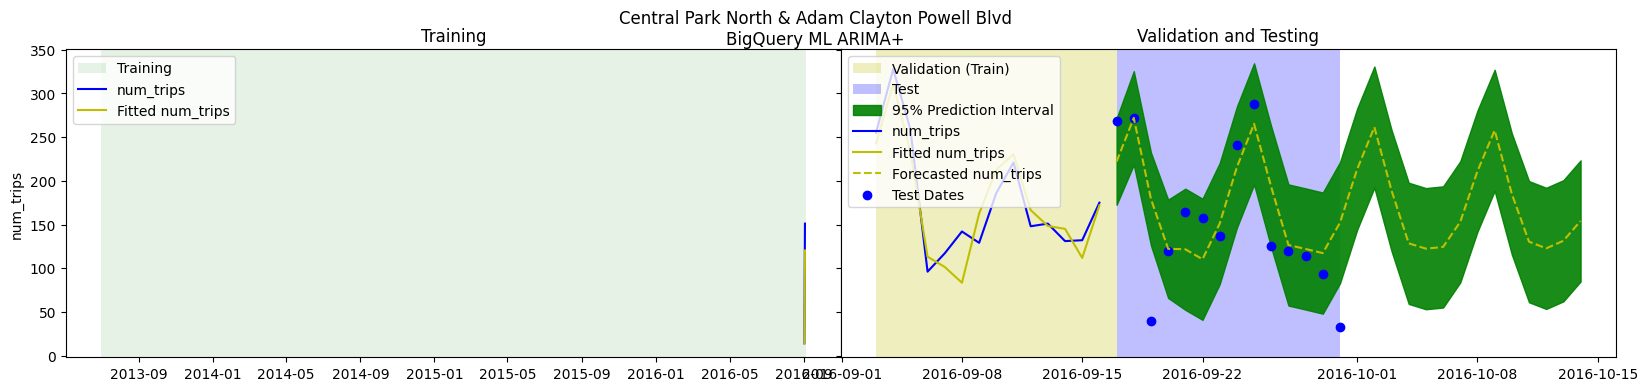

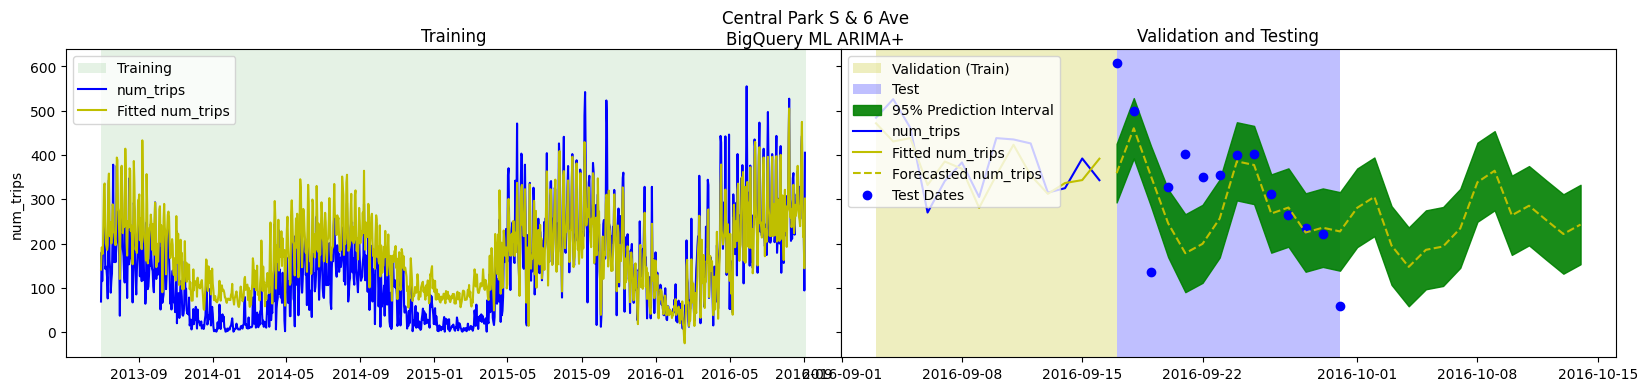

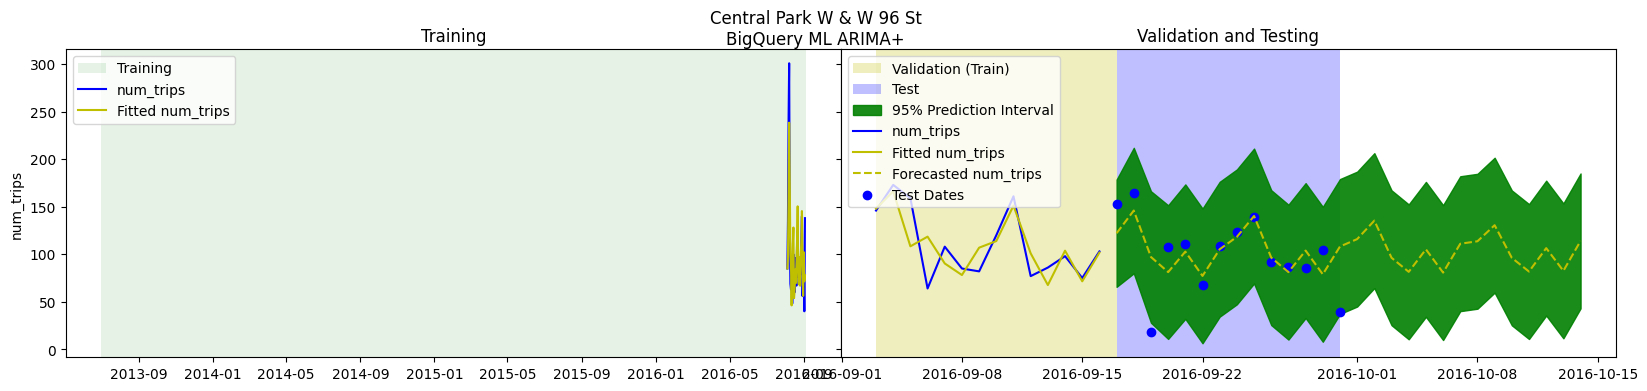

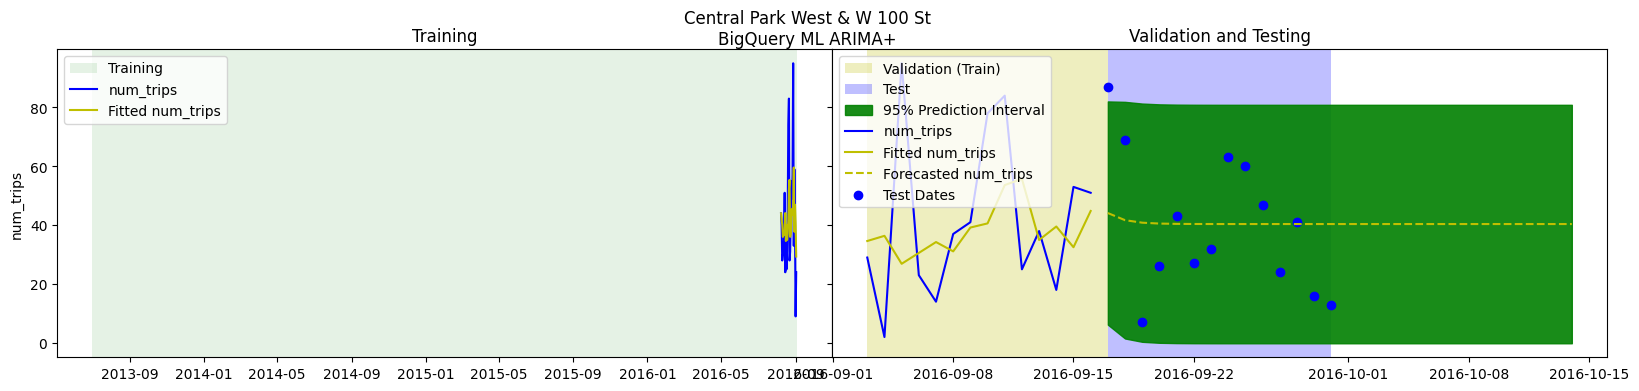

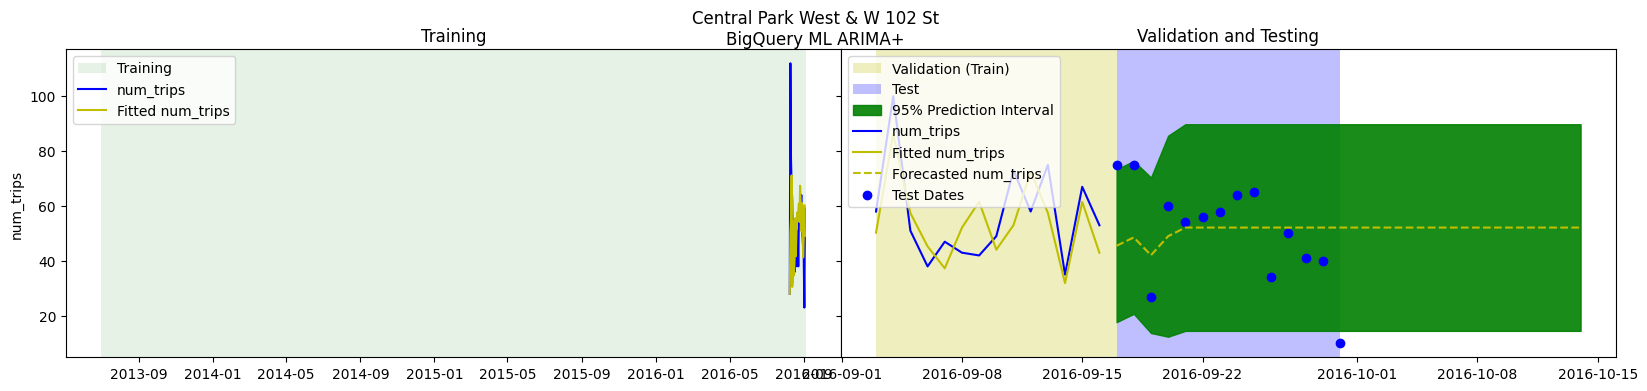

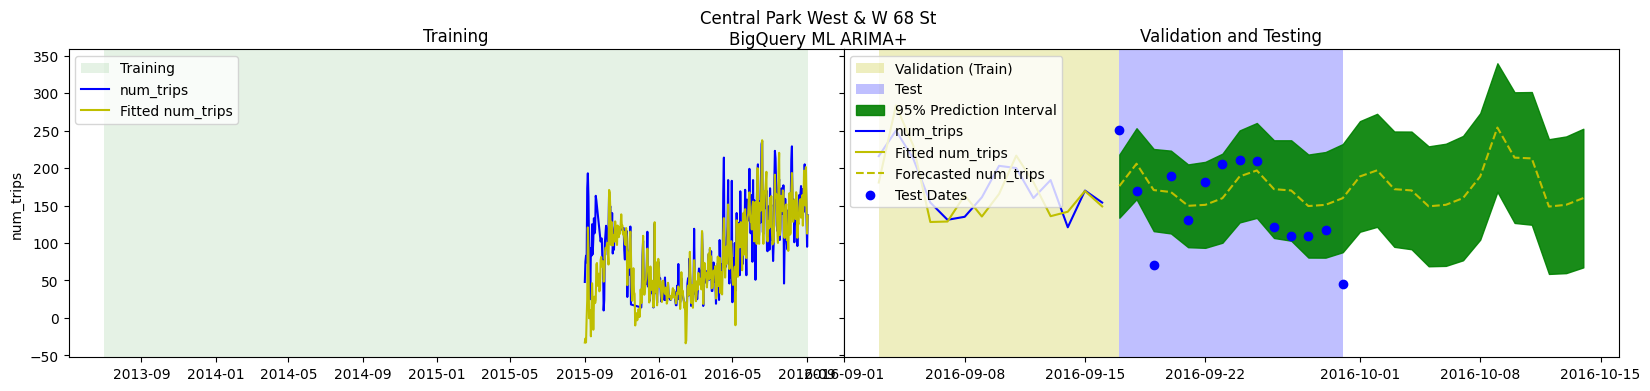

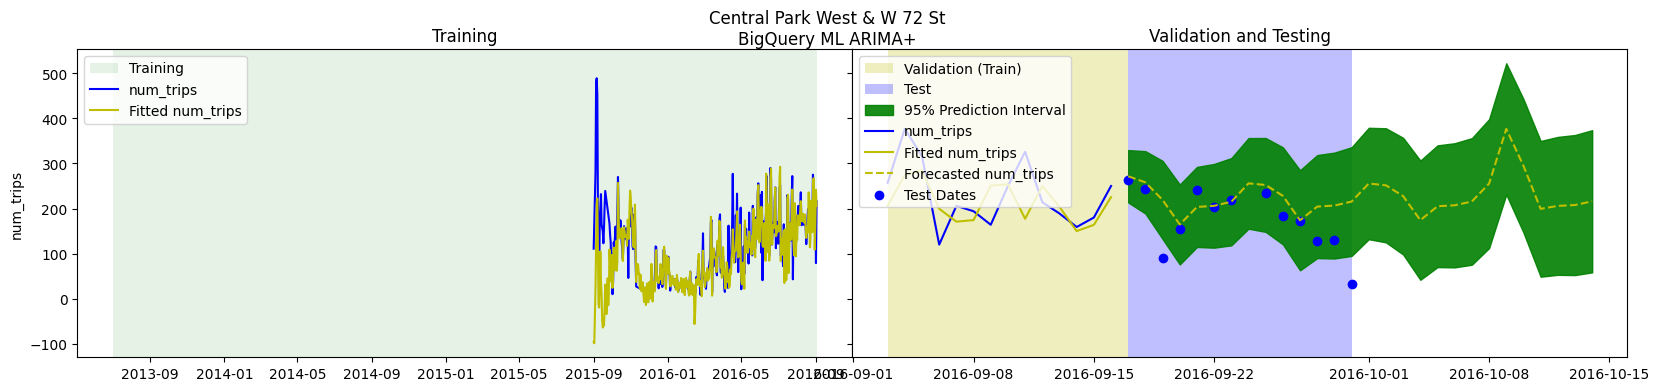

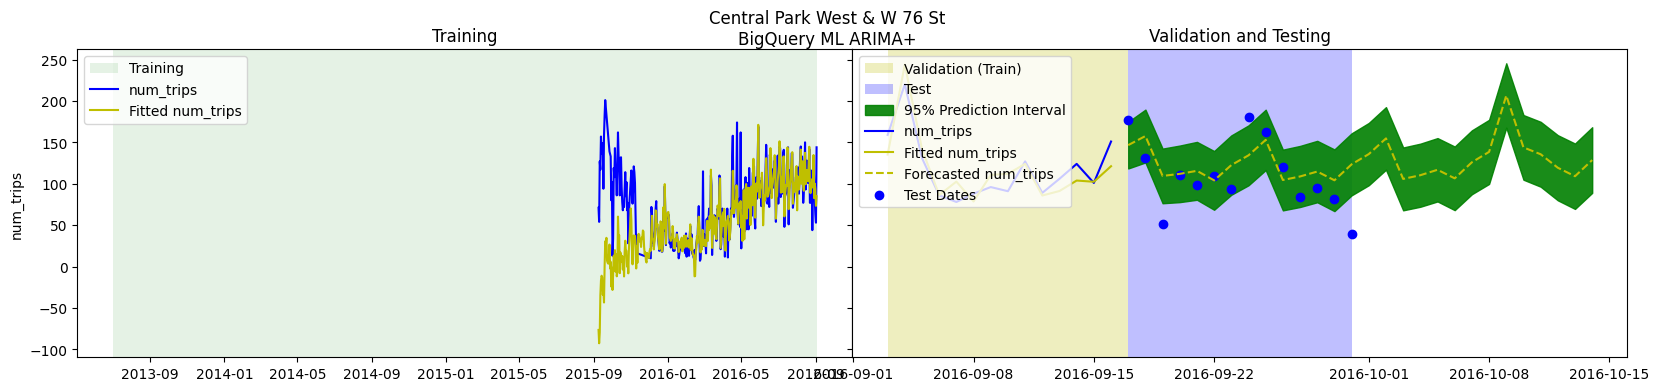

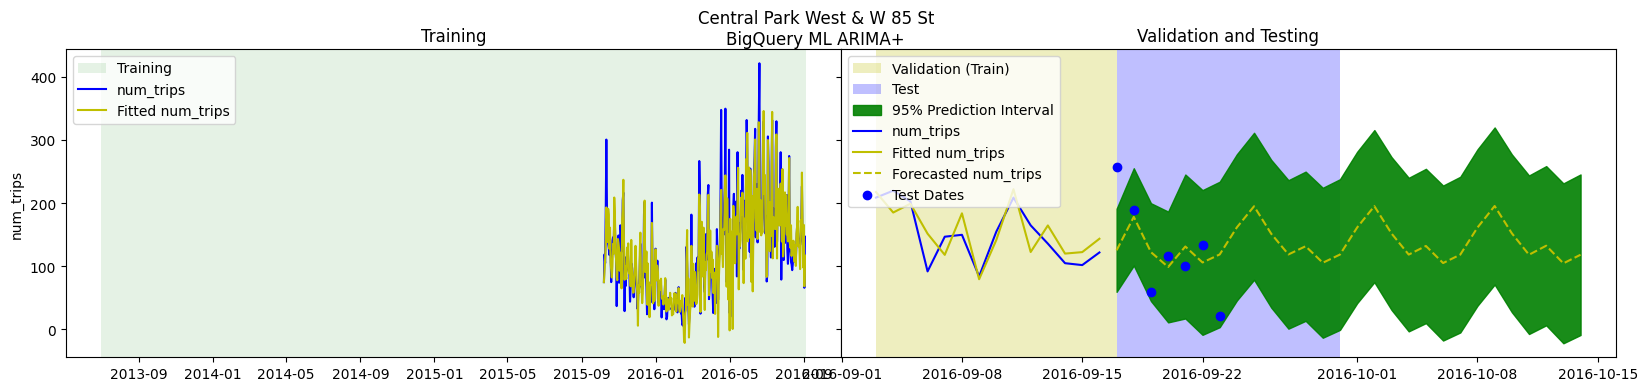

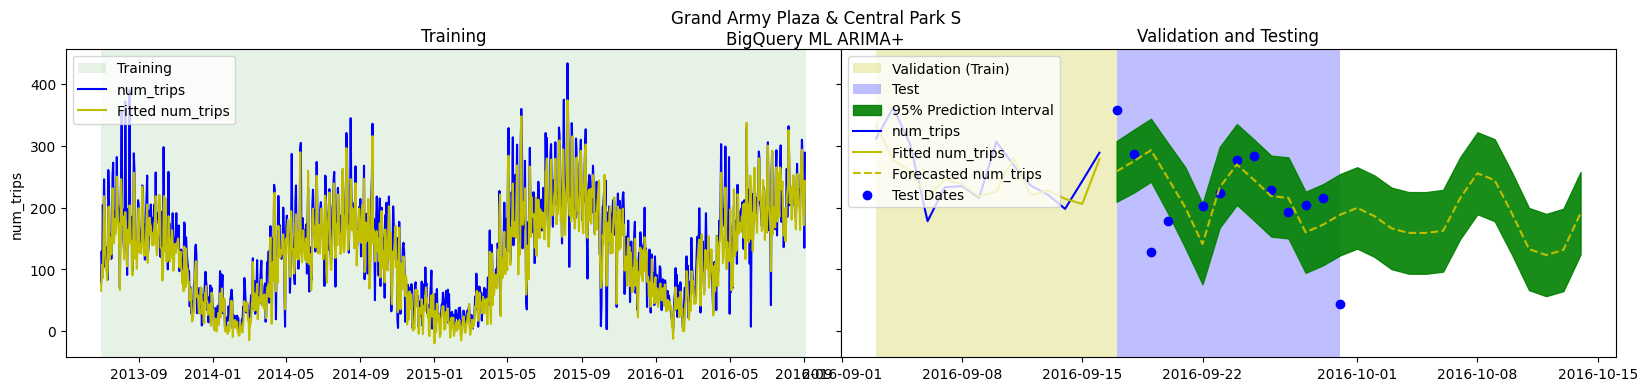

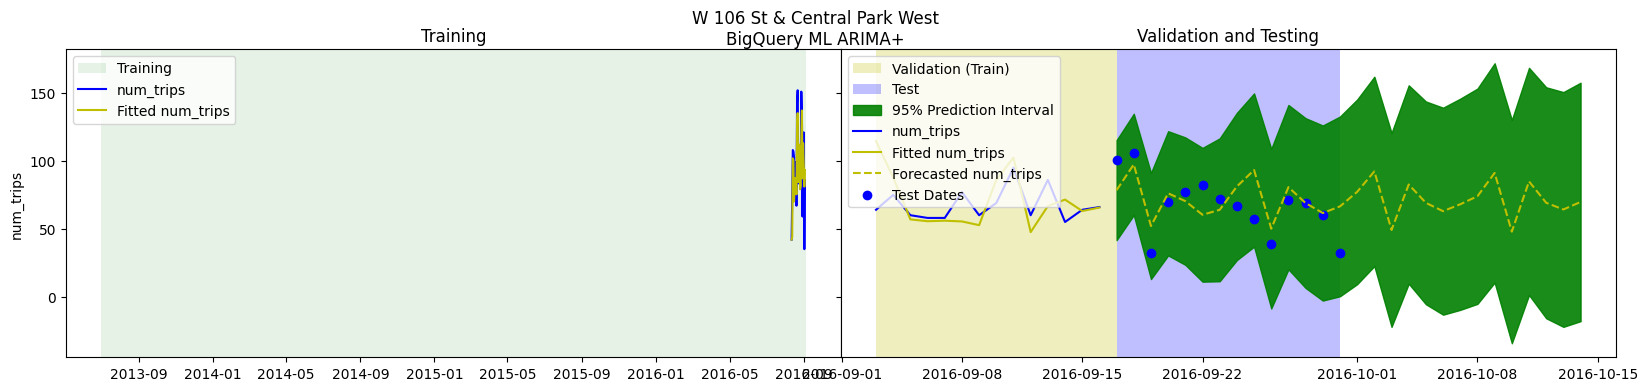

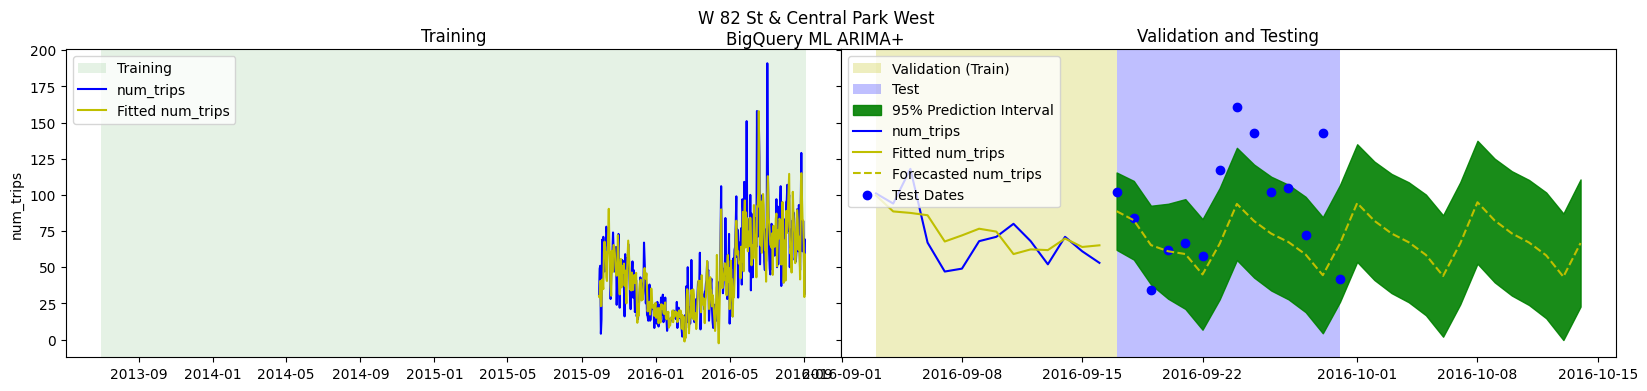

In [21]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]
        fit_traindf = explain[(explain[SERIES_COLUMN] == st) & (explain[TIME_COLUMN] < keyDates['val_start'][0])]
        fit_valdf = explain[(explain[SERIES_COLUMN] == st) & (explain[TIME_COLUMN] >= keyDates['val_start'][0]) & (explain[TIME_COLUMN] < keyDates['test_start'][0])]
        fit_testdf = explain[(explain[SERIES_COLUMN] == st) & (explain[TIME_COLUMN] >= keyDates['test_start'][0])]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
        axes[1].fill_between(fit_testdf[TIME_COLUMN], fit_testdf['prediction_interval_lower_bound'], fit_testdf['prediction_interval_upper_bound'], color = 'g', alpha = 0.9, label = '95% Prediction Interval')

        # lines and dots
        axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        #axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')

        axes[0].plot(fit_traindf[TIME_COLUMN], fit_traindf['time_series_adjusted_data'], color = 'y', label = f'Fitted {TARGET_COLUMN}')
        axes[1].plot(fit_valdf[TIME_COLUMN], fit_valdf['time_series_adjusted_data'], color = 'y', label = f'Fitted {TARGET_COLUMN}')
        axes[1].plot(fit_testdf[TIME_COLUMN], fit_testdf['time_series_adjusted_data'], color = 'y', label = f'Forecasted {TARGET_COLUMN}', linestyle='dashed')

        axes[1].scatter(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b', label = 'Test Dates')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st + f"\nBigQuery ML ARIMA+")

        # display result
        plt.show()

### Review Custom Metrics with SQL

Some common metrics for evaluating forecasting effectiveness are 
- MAPE, or Mean Absolute Percentage Error
    - $\textrm{MAPE} = \frac{1}{n}\sum{\frac{\mid(actual - forecast)\mid}{actual}}$
- MAE, or Mean Absolute Error
     - $\textrm{MAE} = \frac{1}{n}\sum{\mid(actual - forecast)\mid}$
- MAE divided by average demand so it yields a % like MAPE
    - $\textrm{pMAE} = \frac{\sum{\mid(actual - forecast)\mid}}{\sum{actual}}$
- MSE, or Mean Squared Error
    - $\textrm{MSE} = \frac{1}{n}\sum{(actual-forecast)^2}$
- RMSE, or Root Mean Squared Error
    - $\textrm{RMSE} = \sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}$
- RMSE divided by average demand so it yeilds a % like MAPE
    - $\textrm{pRMSE} = \frac{\sqrt{\frac{1}{n}\sum{(actual-forecast)^2}}}{\frac{1}{n}\sum{actual}}$

It can be helpful to explicity caculate these to make comparison between datasets and models fair.  This section demonstration these calculation with SQL.

In [22]:
query = f"""
    WITH
        FORECAST AS (
            SELECT
                {SERIES_COLUMN}, 
                EXTRACT(DATE from time_series_timestamp) as {TIME_COLUMN},
                time_series_adjusted_data as forecast_value,
                time_series_type
            FROM ML.EXPLAIN_FORECAST(
                MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus_{MODEL_VERSION}`,
                STRUCT({forecast_test_length} AS horizon, 0.95 AS confidence_level))
            WHERE time_series_type = 'forecast'
        ),
        ACTUAL AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, sum({TARGET_COLUMN}) as actual_value
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            WHERE splits = 'TEST'
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        ),
        COMBINED AS (
            SELECT *
            FROM FORECAST
            INNER JOIN ACTUAL
            USING ({SERIES_COLUMN}, {TIME_COLUMN})  
        ),
        DIFFS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, 'forecast' as time_series_type, 
                actual_value, forecast_value, (actual_value - forecast_value) as diff
            FROM COMBINED
        )
    SELECT {SERIES_COLUMN}, time_series_type, 
            AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
            AVG(ABS(diff)) as MAE,
            SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
            AVG(POW(diff, 2)) as MSE,
            SQRT(AVG(POW(diff, 2))) as RMSE,
            SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    GROUP BY {SERIES_COLUMN}, time_series_type
    ORDER BY {SERIES_COLUMN}, time_series_type    
"""
customMetrics = bq.query(query = query).to_dataframe()
customMetrics.head(viz_limit)

start_station_name time_series_type      MAPE  \
0   Central Park North & Adam Clayton Powell Blvd         forecast  0.654976   
1                          Central Park S & 6 Ave         forecast  0.485847   
2                        Central Park W & W 96 St         forecast  0.541691   
3                    Central Park West & W 100 St         forecast  0.875371   
4                    Central Park West & W 102 St         forecast  0.531504   
5                     Central Park West & W 68 St         forecast  0.495455   
6                     Central Park West & W 72 St         forecast  0.677052   
7                     Central Park West & W 76 St         forecast  0.389467   
8                     Central Park West & W 85 St         forecast  0.952959   
9               Grand Army Plaza & Central Park S         forecast  0.497448   
10                   W 106 St & Central Park West         forecast  0.275309   
11                    W 82 St & Central Park West         forecast  0.342769   

          MAE      pMAE           MSE        RMSE     pRMSE  
0   40.519533  0.261055   3339.344260   57.787060  0.372305  
1   96.392810  0.295360  16518.326662  128.523642  0.393813  
2   21.729312  0.217138   1016.374801   31.880634  0.318579  
3   18.610058  0.469443    482.209233   21.959263  0.553927  
4   14.568555  0.287672    332.562812   18.236305  0.360096  
5   47.343426  0.312498   3120.673286   55.862987  0.368733  
6   46.421029  0.262380   5039.529907   70.989646  0.401246  
7   27.917248  0.254952   1238.418789   35.191175  0.321381  
8   53.979223  0.429380   4709.508389   68.625858  0.545888  
9   56.139488  0.258158   5640.988045   75.106511  0.345378  
10  14.356956  0.214970    323.219810   17.978315  0.269194  
11  32.113632  0.347981   1781.537621   42.208265  0.457365

In [23]:
query = f"""
    WITH
        FORECAST AS (
            SELECT
                {SERIES_COLUMN}, 
                EXTRACT(DATE from time_series_timestamp) as {TIME_COLUMN},
                time_series_adjusted_data as forecast_value,
                time_series_type
            FROM ML.EXPLAIN_FORECAST(
                MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus_{MODEL_VERSION}`, 
                STRUCT({forecast_test_length} AS horizon, 0.95 AS confidence_level))
            WHERE time_series_type = 'forecast'
        ),
        ACTUAL AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, sum({TARGET_COLUMN}) as actual_value
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            WHERE splits = 'TEST'
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        ),
        COMBINED AS (
            SELECT *
            FROM FORECAST
            INNER JOIN ACTUAL
            USING ({SERIES_COLUMN}, {TIME_COLUMN})  
        ),
        DIFFS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, 'forecast' as time_series_type, 
                actual_value, forecast_value, (actual_value - forecast_value) as diff
            FROM COMBINED
        )
    SELECT time_series_type, 
        AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
        AVG(ABS(diff)) as MAE,
        SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
        AVG(POW(diff, 2)) as MSE,
        SQRT(AVG(POW(diff, 2))) as RMSE,
        SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    GROUP BY time_series_type
    ORDER BY time_series_type    
"""
customMetricsOverall = bq.query(query).to_dataframe()
customMetricsOverall

time_series_type      MAPE        MAE      pMAE          MSE       RMSE  \
0         forecast  0.542344  38.370206  0.286493  3559.437949  59.661025   

      pRMSE  
0  0.445462

## Log Vertex Experiments

In [24]:
from datetime import datetime

# create run name
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
EXPERIMENT_RUN_NAME = f"run-{TIMESTAMP}"

# log params and metrics to dicts
params = {}
# params["budget_hrs"] = MILLI_NODE_HRS
params["horizon"] = forecast_horizon
# params["context_window"] = CONTEXT_WINDOW
params["model_type"] = "arimaplus"

metrics_dict = {}
metrics_dict["MAPE"] = customMetricsOverall['MAPE'][0]
metrics_dict["MAE"] = customMetricsOverall['MAE'][0]
metrics_dict["pMAE"] = customMetricsOverall['pMAE'][0]
metrics_dict["MSE"] = customMetricsOverall['MSE'][0]
metrics_dict["RMSE"] = customMetricsOverall['RMSE'][0]
metrics_dict["pRMSE"] = customMetricsOverall['pRMSE'][0]

# # Create and log experiment
vertex_ai.init(experiment=EXPERIMENT_NAME.replace("_","-"))

with vertex_ai.start_run(EXPERIMENT_RUN_NAME) as my_run:
    my_run.log_metrics(metrics_dict)
    my_run.log_params(params)

    vertex_ai.end_run()

Associating projects/934903580331/locations/us-central1/metadataStores/default/contexts/nyc-jtv3-forecasting-run-20230515113430 to Experiment: nyc-jtv3-forecasting


## Anomaly Detection
* Reference for `ML.DETECT_ANOMALIES`

In [25]:
query = f"""
    SELECT * EXCEPT({TIME_COLUMN}), CAST(DATE({TIME_COLUMN}) AS date) AS {TIME_COLUMN}
    FROM ML.DETECT_ANOMALIES(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplus_{MODEL_VERSION}`,
        STRUCT(0.95 as anomaly_prob_threshold),
        (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN}
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
        )
        )
    WHERE anomaly_probability >= 0.95
"""
anomalies = bq.query(query).to_dataframe()
anomalies.head(viz_limit)

start_station_name  num_trips  is_anomaly  \
0                     Central Park West & W 85 St      258.0        True   
1                    Central Park West & W 102 St       10.0        True   
2                        Central Park W & W 96 St       18.0        True   
3                     Central Park West & W 72 St       33.0        True   
4   Central Park North & Adam Clayton Powell Blvd       33.0        True   
5                     W 82 St & Central Park West       34.0        True   
6                     Central Park West & W 76 St       39.0        True   
7   Central Park North & Adam Clayton Powell Blvd       39.0        True   
8               Grand Army Plaza & Central Park S       43.0        True   
9                     Central Park West & W 68 St       45.0        True   
10                    Central Park West & W 76 St       51.0        True   
11                         Central Park S & 6 Ave       60.0        True   

    lower_bound  upper_bound  anomaly_probability   starttime  
0     59.542503   191.342093             0.999786  2016-09-17  
1     14.513120    89.791480             0.971694  2016-09-30  
2     27.933173   166.329331             0.974811  2016-09-19  
3     94.878380   336.028699             0.996466  2016-09-30  
4     82.696895   221.440264             0.998872  2016-09-30  
5     38.050623    92.495964             0.975460  2016-09-19  
6     86.004782   160.874084             0.999944  2016-09-30  
7    125.923309   232.359466             0.999992  2016-09-19  
8    122.559097   254.244776             0.999927  2016-09-30  
9     87.716152   232.015594             0.997726  2016-09-30  
10    76.455194   142.443263             0.999174  2016-09-19  
11   138.588384   315.971621             0.999567  2016-09-30

### Visualize Time Series with Forecast and Anomalies

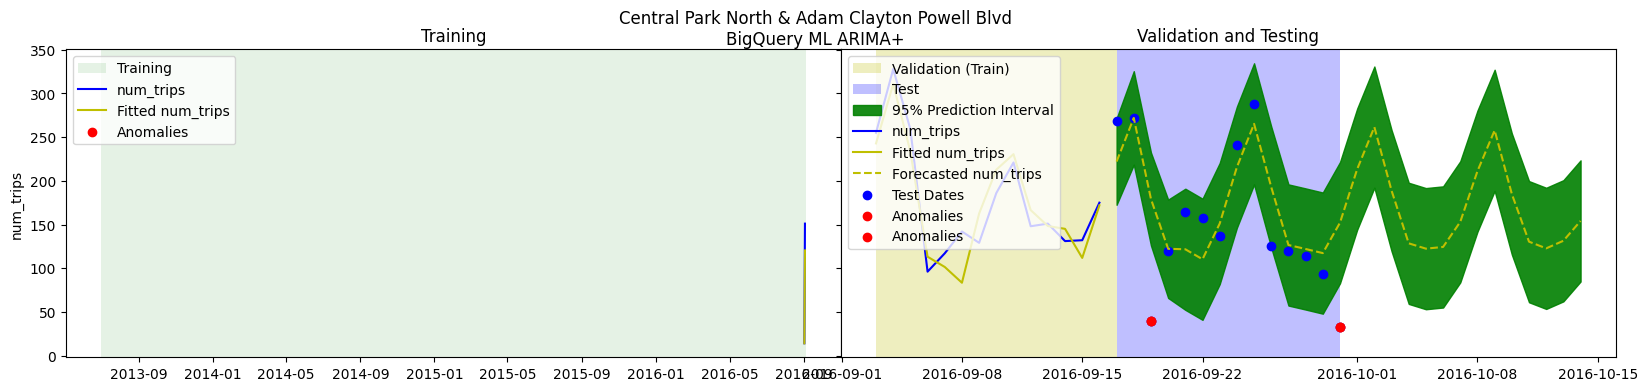

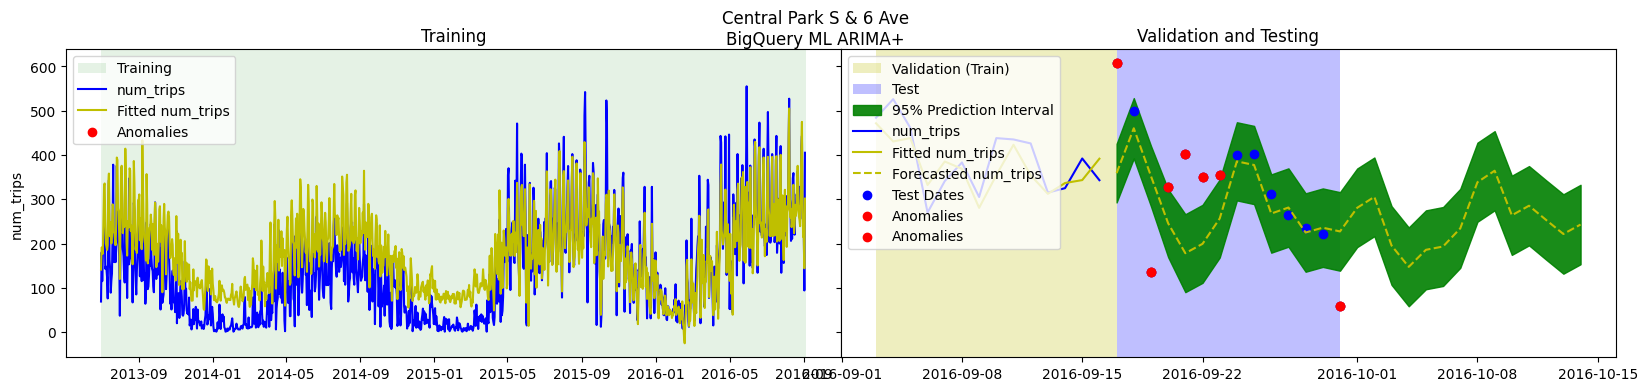

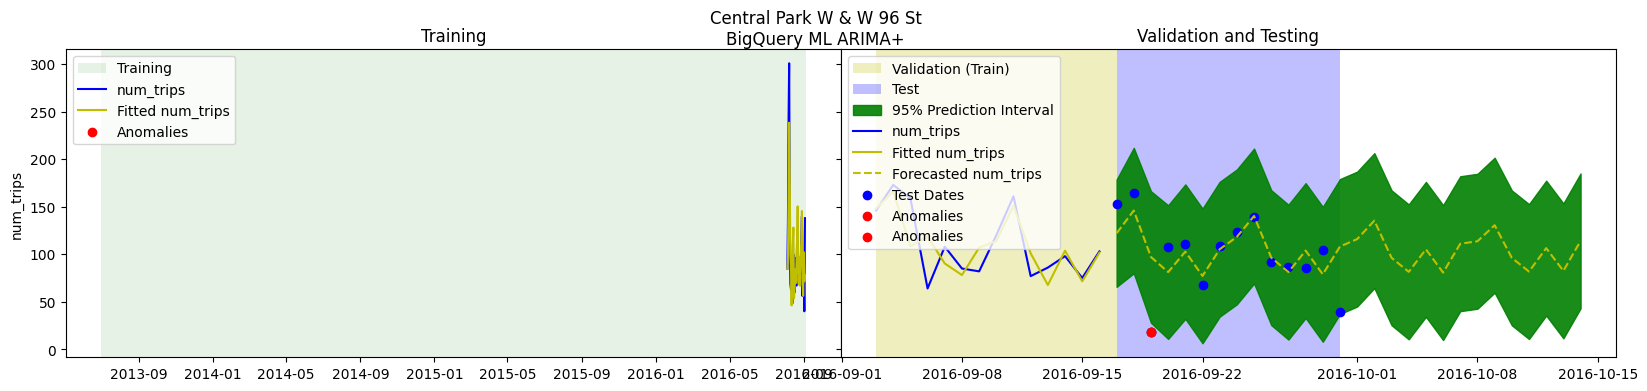

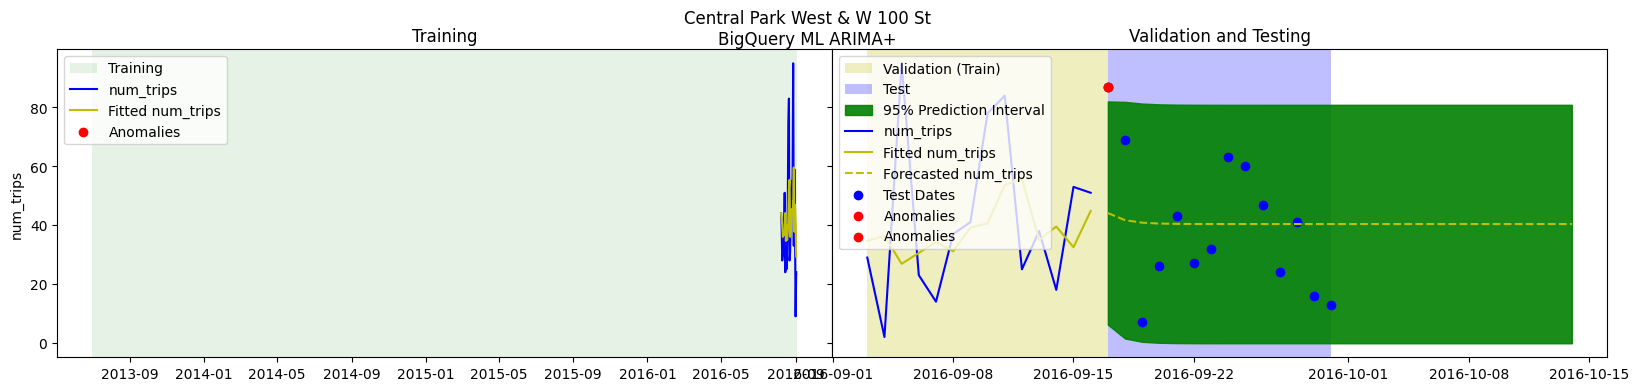

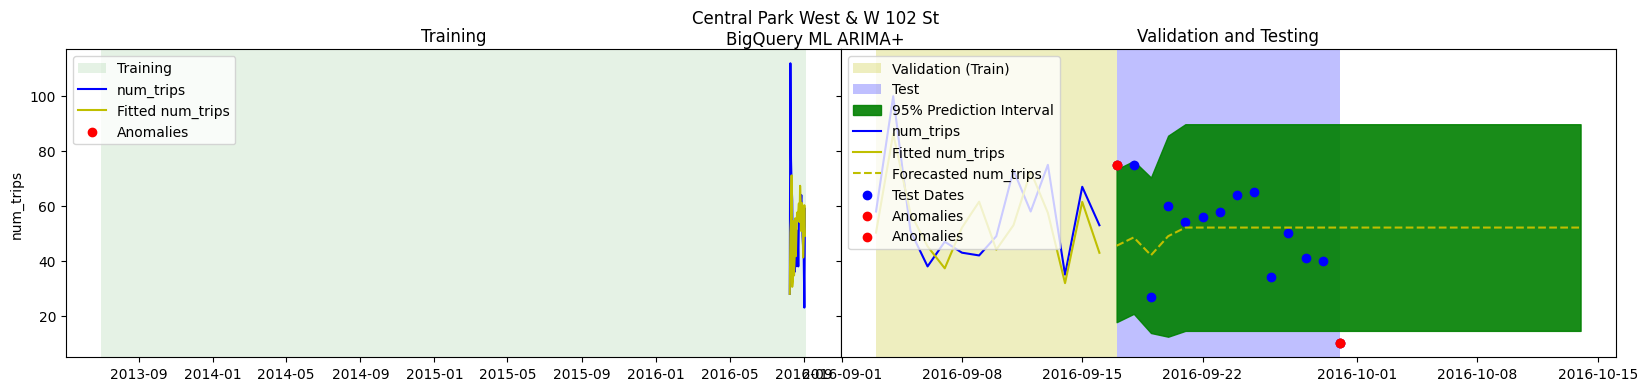

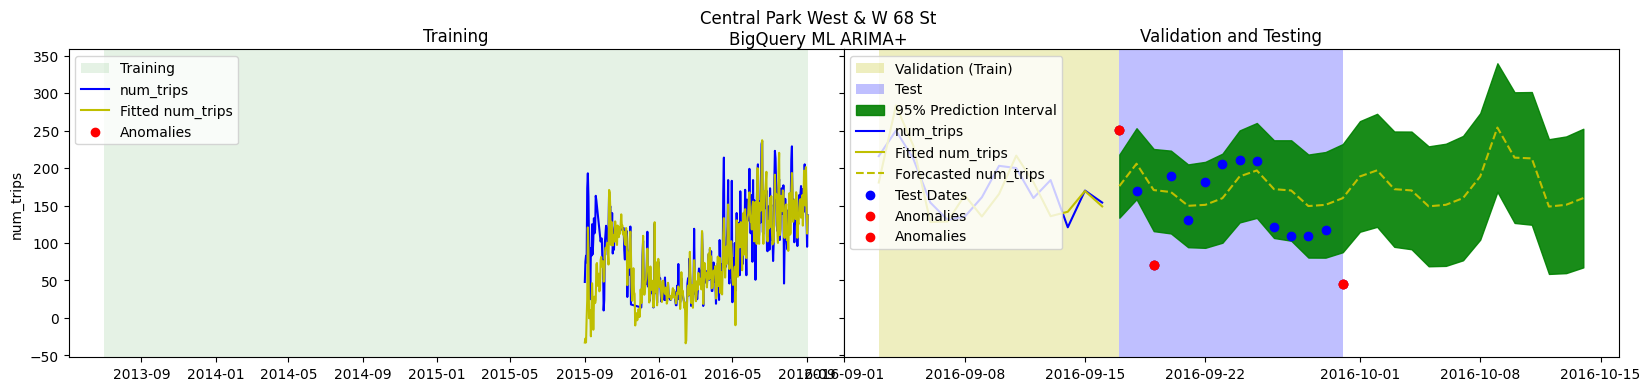

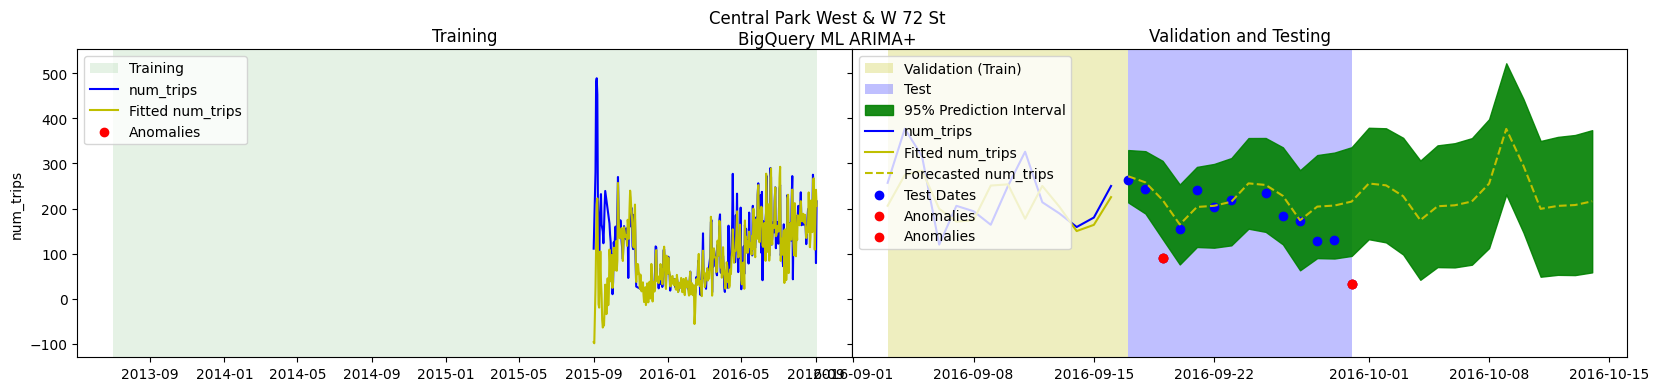

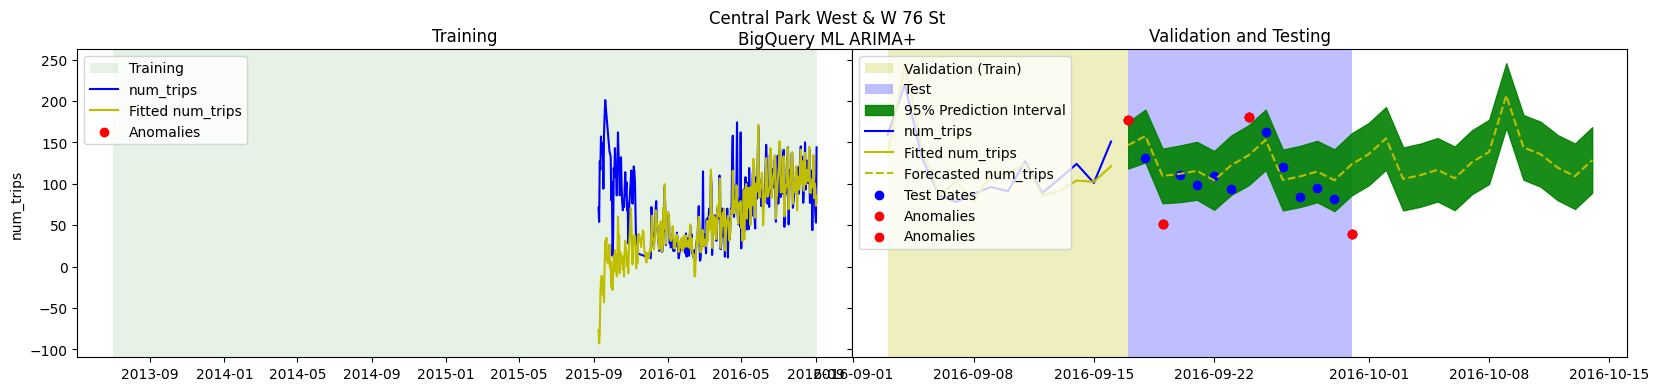

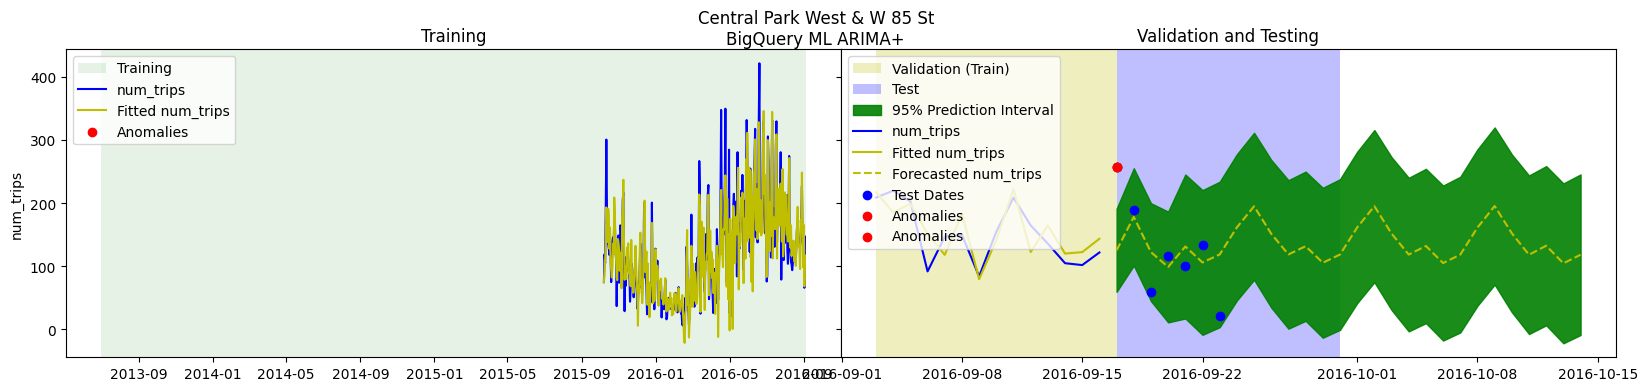

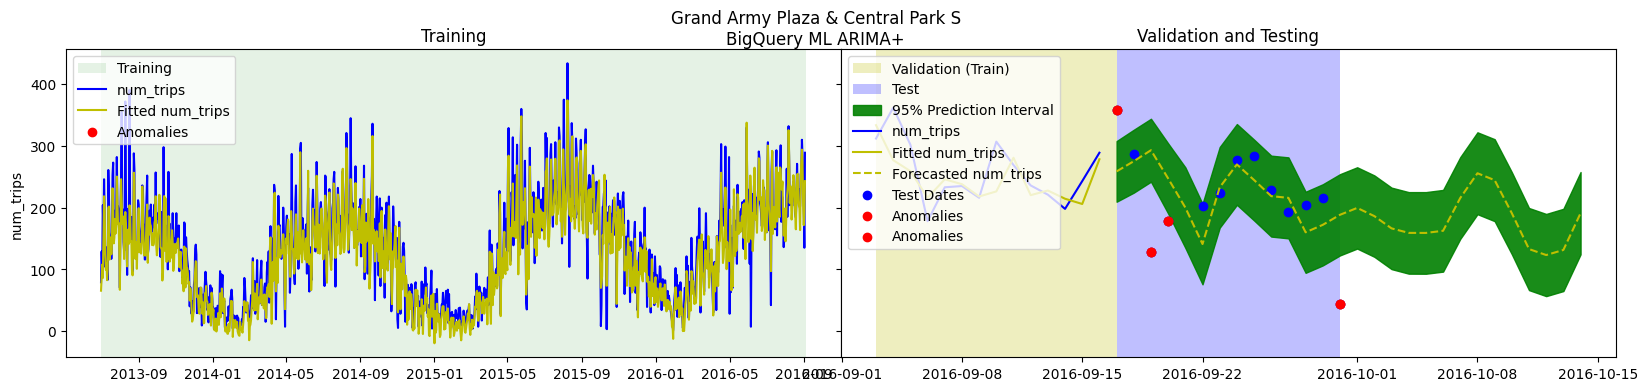

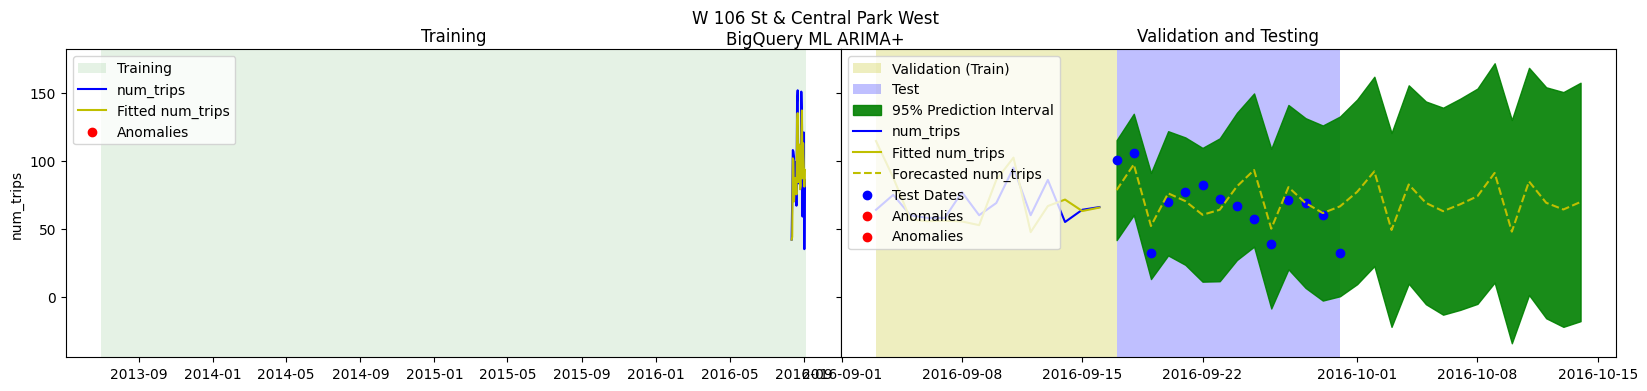

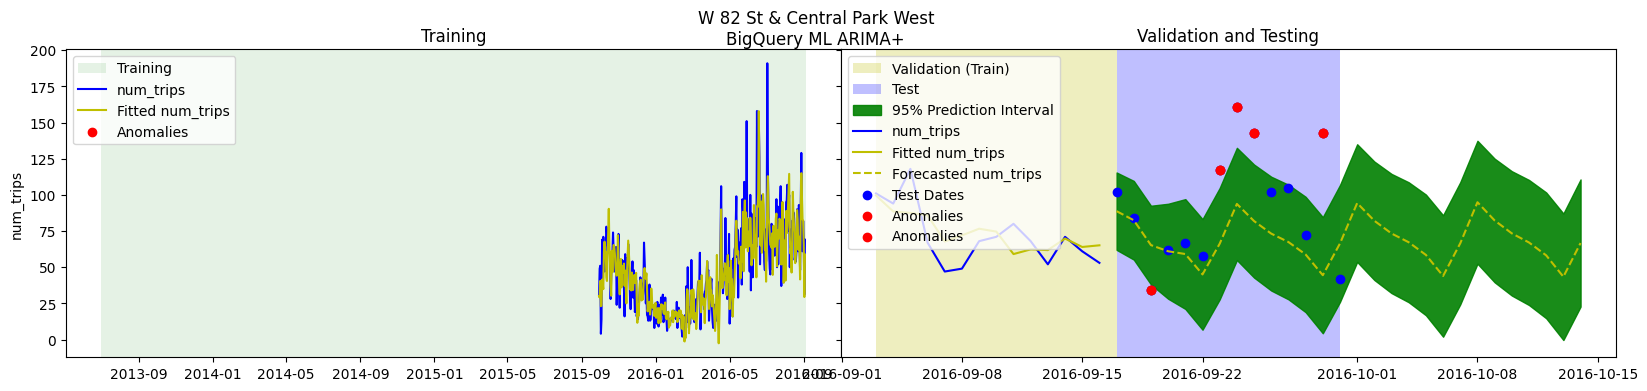

In [26]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]
        fit_traindf = explain[(explain[SERIES_COLUMN] == st) & (explain[TIME_COLUMN] < keyDates['val_start'][0])]
        fit_valdf = explain[(explain[SERIES_COLUMN] == st) & (explain[TIME_COLUMN] >= keyDates['val_start'][0]) & (explain[TIME_COLUMN] < keyDates['test_start'][0])]
        fit_testdf = explain[(explain[SERIES_COLUMN] == st) & (explain[TIME_COLUMN] >= keyDates['test_start'][0])]
        anomalies_traindf = anomalies[(anomalies[SERIES_COLUMN] == st) & (anomalies[TIME_COLUMN] < keyDates['val_start'][0])]
        anomalies_valdf = anomalies[(anomalies[SERIES_COLUMN] == st) & (anomalies[TIME_COLUMN] >= keyDates['val_start'][0])]
        anomalies_testdf = anomalies[(anomalies[SERIES_COLUMN] == st) & (anomalies[TIME_COLUMN] >= keyDates['test_start'][0])]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
        axes[1].fill_between(fit_testdf[TIME_COLUMN], fit_testdf['prediction_interval_lower_bound'], fit_testdf['prediction_interval_upper_bound'], color = 'g', alpha = 0.9, label = '95% Prediction Interval')

        # lines and dots
        axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        #axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')

        axes[0].plot(fit_traindf[TIME_COLUMN], fit_traindf['time_series_adjusted_data'], color = 'y', label = f'Fitted {TARGET_COLUMN}')
        axes[1].plot(fit_valdf[TIME_COLUMN], fit_valdf['time_series_adjusted_data'], color = 'y', label = f'Fitted {TARGET_COLUMN}')
        axes[1].plot(fit_testdf[TIME_COLUMN], fit_testdf['time_series_adjusted_data'], color = 'y', label = f'Forecasted {TARGET_COLUMN}', linestyle='dashed')

        axes[1].scatter(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b', label = 'Test Dates')

        axes[0].scatter(anomalies_traindf[TIME_COLUMN], anomalies_traindf[TARGET_COLUMN], color = 'r', label = 'Anomalies')
        axes[1].scatter(anomalies_valdf[TIME_COLUMN], anomalies_valdf[TARGET_COLUMN], color = 'r', label = 'Anomalies')
        axes[1].scatter(anomalies_testdf[TIME_COLUMN], anomalies_testdf[TARGET_COLUMN], color = 'r', label = 'Anomalies')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st + f"\nBigQuery ML ARIMA+")

        # display result
        plt.show()

# Register model in Vertex AI Model Registry

In [27]:
# Initiate Vertex AI Model Registry for `VERTEX_AI_MODEL_ID` model entry
registry = vertex_ai.models.ModelRegistry(VERTEX_AI_MODEL_ID)

In [28]:
# Get model versions
versions = registry.list_versions()

for version in versions:
    version_id = version.version_id
    version_created_time = datetime.fromtimestamp(
        version.version_create_time.timestamp()
    ).strftime("%m/%d/%Y %H:%M:%S")
    version_aliases = version.version_aliases
    print(
        f"Model version {version_id} was created at {version_created_time} with aliases {version_aliases}",
    )

Getting versions for projects/hybrid-vertex/locations/us-central1/models/v1_arima
Model version 2 was created at 05/15/2023 10:40:24 with aliases ['default']
Model version 3 was created at 05/15/2023 11:28:35 with aliases ['v1']
Model version 4 was created at 05/15/2023 11:30:36 with aliases ['v2', 'experimental']
